In [206]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [207]:
pd.set_option('display.max_columns', 200)
pd.set_option('display.float_format', lambda x: f"{x:.4f}")


# **Cell 2: Load dataset**

In [208]:
df = pd.read_csv('/content/Cardiotocographic.csv')

# **Cell 3: Initial data info**

In [209]:
print('Rows, Columns:', df.shape)
df.head()

Rows, Columns: (2126, 14)


,LB,AC,FM,UC,DL,DS,DP,ASTV,MSTV,ALTV,MLTV,Width,Tendency,NSP
0,120.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,73.0000,0.5000,43.0000,2.4000,64.0000,0.9999,2.0000
1,132.0000,0.0064,0.0000,0.0064,0.0032,0.0000,0.0000,17.0000,2.1000,0.0000,10.4000,130.0000,0.0000,1.0000
2,133.0000,0.0033,0.0000,0.0083,0.0033,0.0000,0.0000,16.0000,2.1000,0.0000,13.4000,130.0000,0.0000,1.0000
3,134.0000,0.0026,0.0000,0.0077,0.0026,0.0000,0.0000,16.0000,2.4000,0.0000,23.0000,117.0000,1.0000,1.0000
4,131.9482,0.0065,0.0000,0.0081,0.0000,0.0000,0.0000,16.0000,2.4000,0.0000,19.9000,117.0000,1.0000,1.0000


In [210]:
print('\n--- Dtypes and non-null counts ---')
print(df.info())


--- Dtypes and non-null counts ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2126 entries, 0 to 2125
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   LB        2105 non-null   float64
 1   AC        2106 non-null   float64
 2   FM        2126 non-null   float64
 3   UC        2126 non-null   float64
 4   DL        2126 non-null   float64
 5   DS        2105 non-null   float64
 6   DP        2105 non-null   float64
 7   ASTV      2126 non-null   float64
 8   MSTV      2126 non-null   float64
 9   ALTV      2126 non-null   float64
 10  MLTV      2105 non-null   float64
 11  Width     2105 non-null   float64
 12  Tendency  2105 non-null   float64
 13  NSP       2105 non-null   float64
dtypes: float64(14)
memory usage: 232.7 KB
None


In [211]:
print('\n--- Missing values per column ---')
print(df.isna().sum())


--- Missing values per column ---
LB          21
AC          20
FM           0
UC           0
DL           0
DS          21
DP          21
ASTV         0
MSTV         0
ALTV         0
MLTV        21
Width       21
Tendency    21
NSP         21
dtype: int64


In [212]:
for col in df.columns:
    if df[col].dtype == 'object':
        sample = df[col].dropna().head(5).tolist()
        if sample:
            print(f"\nColumn '{col}' is object. Example values: {sample}")

# **Cell 4: Data cleaning & type conversion**

In [213]:
numeric_cols = []
for col in df.columns:
    if df[col].dtype == 'float64':  # Check if the column is numeric (float64 in this case)
        numeric_cols.append(col)
    print(col)

LB
AC
FM
UC
DL
DS
DP
ASTV
MSTV
ALTV
MLTV
Width
Tendency
NSP


In [214]:
numeric_cols = []
for col in df.columns:

    if df[col].dtype == 'object':
            df[col] = df[col].str.strip()

            df[col] = df[col].str.replace(',', '.')
            df[col] = pd.to_numeric(df[col], errors='raise')
            numeric_cols.append(col)



In [215]:
print('Converted to numeric (if any):', numeric_cols)

Converted to numeric (if any): []


In [216]:
num_df = df.select_dtypes(include=[np.number]).copy()
cat_df = df.select_dtypes(exclude=[np.number]).copy()
print('\nNumeric columns detected:', list(num_df.columns))
print('Categorical/other columns detected:', list(cat_df.columns))


Numeric columns detected: ['LB', 'AC', 'FM', 'UC', 'DL', 'DS', 'DP', 'ASTV', 'MSTV', 'ALTV', 'MLTV', 'Width', 'Tendency', 'NSP']
Categorical/other columns detected: []


# **Cell 5: Handle missing values**

In [217]:
missing_frac = df.isna().mean().sort_values(ascending=False)
missing_frac = missing_frac[missing_frac > 0]
print('\nColumns with missing values and fractions:')
print(missing_frac)


Columns with missing values and fractions:
LB         0.0099
DS         0.0099
MLTV       0.0099
Width      0.0099
Tendency   0.0099
DP         0.0099
NSP        0.0099
AC         0.0094
dtype: float64


In [218]:
imputed_df = df.copy()
for col in imputed_df.select_dtypes(include=[np.number]).columns:
    if imputed_df[col].isna().any():
        imputed_df[col] = imputed_df[col].fillna(imputed_df[col].median())

In [219]:
for col in imputed_df.select_dtypes(exclude=[np.number]).columns:
    if imputed_df[col].isna().any():
        imputed_df[col].fillna(imputed_df[col].mode().iloc[0] if not imputed_df[col].mode().empty else 'Missing', inplace=True)

In [220]:
print('\nMissing values after median/mode imputation:')
print(imputed_df.isna().sum().sum())


Missing values after median/mode imputation:
0


# **Cell 6: Detect and treat outliers (IQR method**)

In [221]:
def mark_outliers_iqr(series, k=1.5):
    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    iqr = q3 - q1
    lower = q1 - k * iqr
    upper = q3 + k * iqr
    return (series < lower) | (series > upper)


outlier_summary = {}
for col in imputed_df.select_dtypes(include=[np.number]).columns:
    mask = mark_outliers_iqr(imputed_df[col].dropna())
    outlier_count = mask.sum()
    outlier_summary[col] = int(outlier_count)


outlier_df = pd.Series(outlier_summary).sort_values(ascending=False)
print('\nOutlier counts (IQR method):')
print(outlier_df.head(15))


Outlier counts (IQR method):
NSP         559
FM          347
ALTV        318
DP          284
DL          125
DS          120
MLTV         81
MSTV         80
AC           43
UC           13
LB           10
ASTV         10
Width        10
Tendency     10
dtype: int64


In [222]:
trimmed = imputed_df.copy()
for col in trimmed.select_dtypes(include=[np.number]).columns:
    mask = mark_outliers_iqr(trimmed[col])
    trimmed = trimmed.loc[~mask]
print('\nTrimmed dataset shape after removing rows that are outliers in any numeric column:', trimmed.shape)


Trimmed dataset shape after removing rows that are outliers in any numeric column: (917, 14)


# **Cell 7: Statistical summary**

In [223]:
num_stats = imputed_df.select_dtypes(include=[np.number]).describe().T

In [224]:
num_stats = imputed_df.select_dtypes(include=[np.number]).describe().T
num_stats['IQR'] = imputed_df.select_dtypes(include=[np.number]).quantile(0.75) - imputed_df.select_dtypes(include=[np.number]).quantile(0.25)
num_stats['median_abs_dev'] = imputed_df.select_dtypes(include=[np.number]).apply(lambda x: np.median(np.abs(x - np.median(x))))
num_stats = num_stats[['count','mean','std','min','25%','50%','75%','max','IQR','median_abs_dev']]
num_stats.rename(columns={'50%':'median','25%':'25%','75%':'75%'}, inplace=True)
num_stats

,count,mean,std,min,25%,median,75%,max,IQR,median_abs_dev
LB,2126.0000,133.3402,11.2144,51.8425,126.0000,133.0000,140.0000,214.0000,14.0000,7.0000
AC,2126.0000,0.0032,0.0044,-0.0193,0.0000,0.0016,0.0056,0.0386,0.0056,0.0016
FM,2126.0000,0.0099,0.0675,-0.4806,0.0000,0.0000,0.0026,0.9613,0.0026,0.0000
UC,2126.0000,0.0044,0.0033,-0.0149,0.0019,0.0045,0.0065,0.0300,0.0047,0.0023
DL,2126.0000,0.0019,0.0033,-0.0154,0.0000,0.0000,0.0033,0.0308,0.0033,0.0000
DS,2126.0000,0.0000,0.0001,-0.0014,0.0000,0.0000,0.0000,0.0027,0.0000,0.0000
DP,2126.0000,0.0002,0.0008,-0.0053,0.0000,0.0000,0.0000,0.0107,0.0000,0.0000
ASTV,2126.0000,46.9960,18.8140,-63.0000,32.0000,49.0000,61.0000,162.0000,29.0000,14.0000
MSTV,2126.0000,1.3644,1.1736,-6.6000,0.7000,1.2000,1.7000,13.8000,1.0000,0.5000
ALTV,2126.0000,10.2860,21.2050,-91.0000,0.0000,0.0000,11.0000,182.0000,11.0000,0.0000


In [225]:
skew_kurt = pd.DataFrame({
'skewness': imputed_df.select_dtypes(include=[np.number]).skew(),
'kurtosis': imputed_df.select_dtypes(include=[np.number]).kurtosis(),
}).sort_values('skewness', key=lambda s: s.abs(), ascending=False)

In [226]:
print('\nColumns with largest absolute skewness/kurtosis:')
print(skew_kurt.head(10))


Columns with largest absolute skewness/kurtosis:
      skewness  kurtosis
DS      8.4613  229.1153
FM      6.7531   94.4723
DP      6.4563   76.7995
MSTV    4.1425   44.0343
MLTV    3.5617   56.5163
ALTV    2.9812   15.9119
AC      2.0324   12.6555
DL      2.0104   12.8579
NSP     1.8269    3.7537
UC      0.9742   10.1275


# **Cell 8: Visualizations — distributions**

In [227]:
numeric_columns = imputed_df.select_dtypes(include=[np.number]).columns.tolist()

# **Histograms and boxplots in a loop. Adjust figure size/cols as needed**.

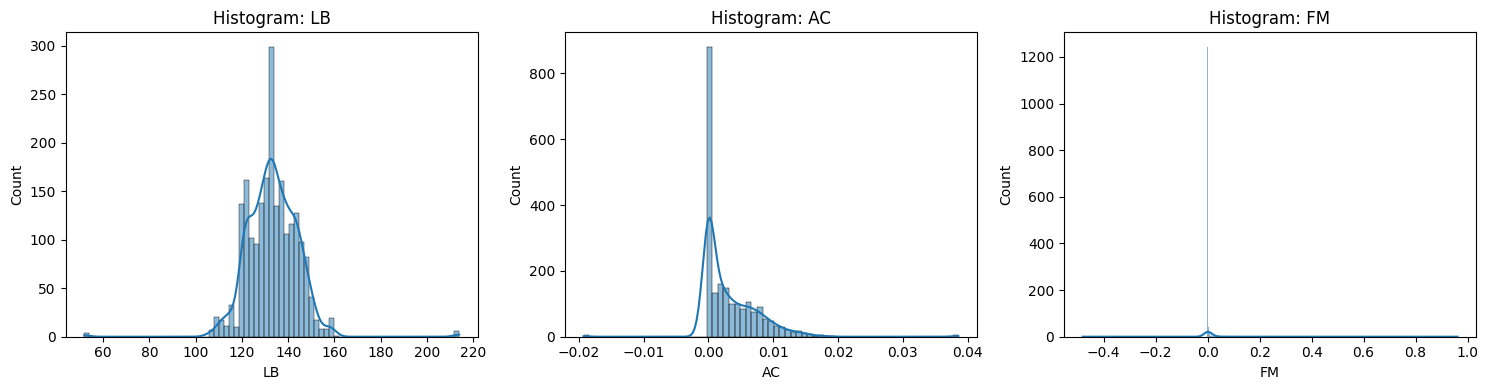

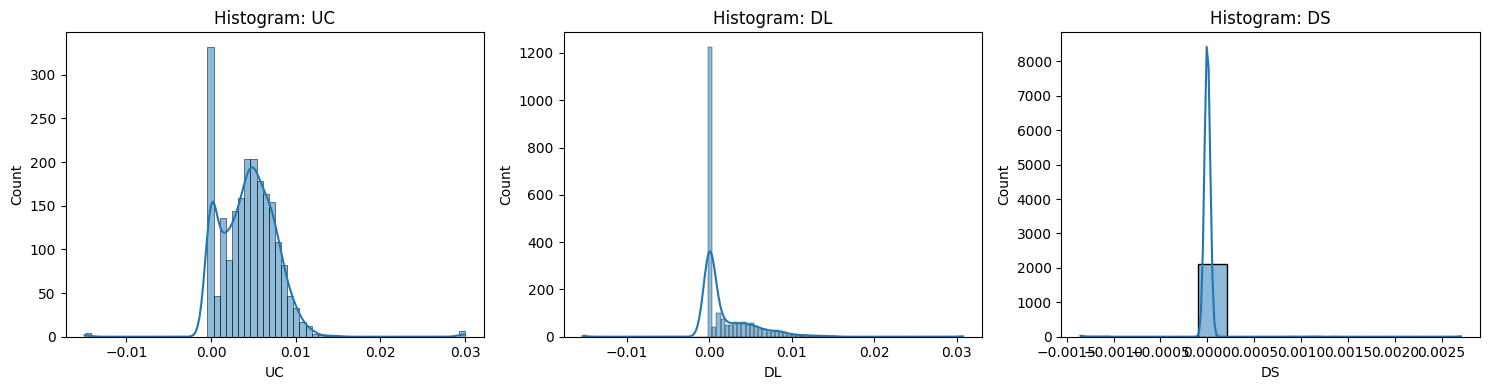

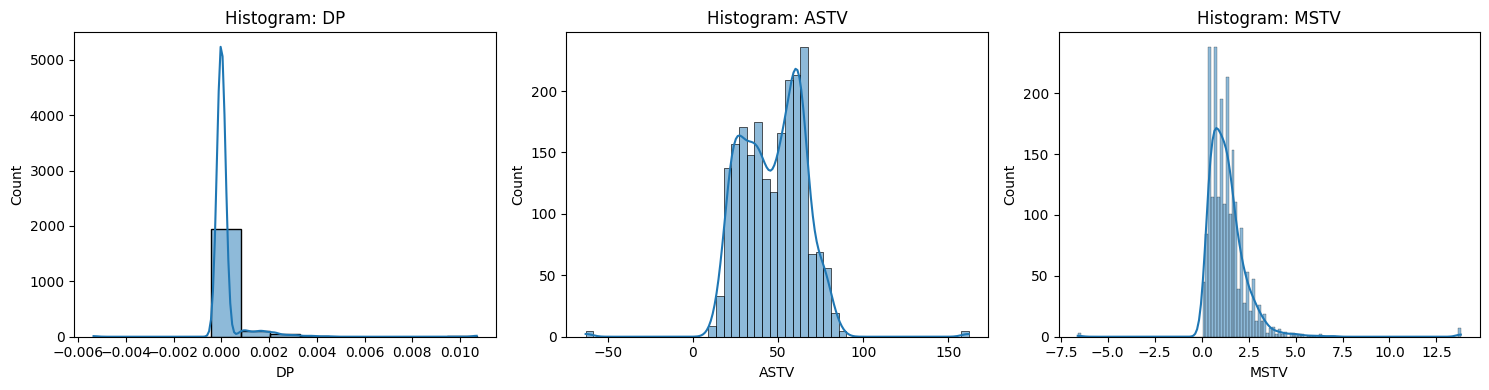

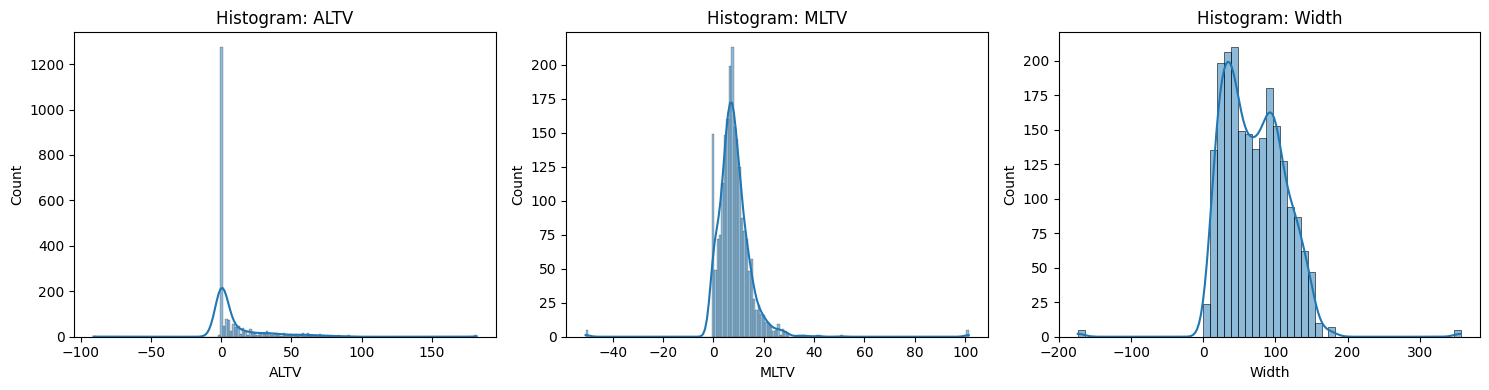

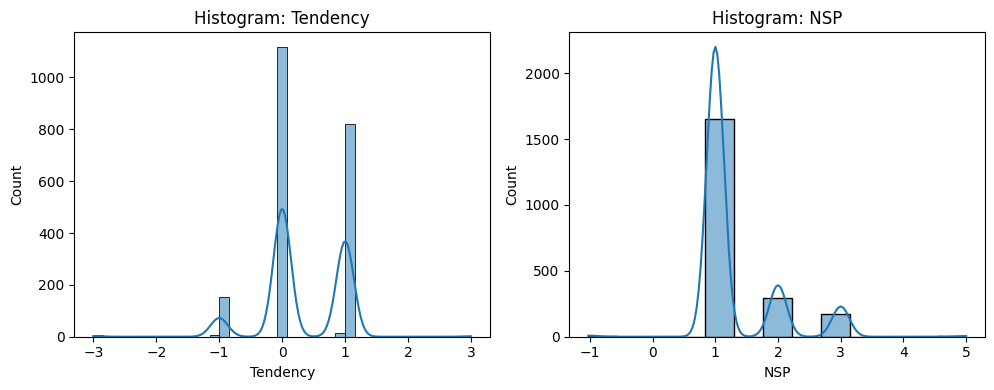

In [228]:
cols_per_row = 3
for i, col in enumerate(numeric_columns):
    if i % cols_per_row == 0:
        plt.figure(figsize=(15, 4))
    plt.subplot(1, cols_per_row, (i % cols_per_row) + 1)
    sns.histplot(imputed_df[col], kde=True)
    plt.title(f'Histogram: {col}')
    if (i + 1) % cols_per_row == 0 or i == len(numeric_columns) - 1:
        plt.tight_layout()
        plt.show()

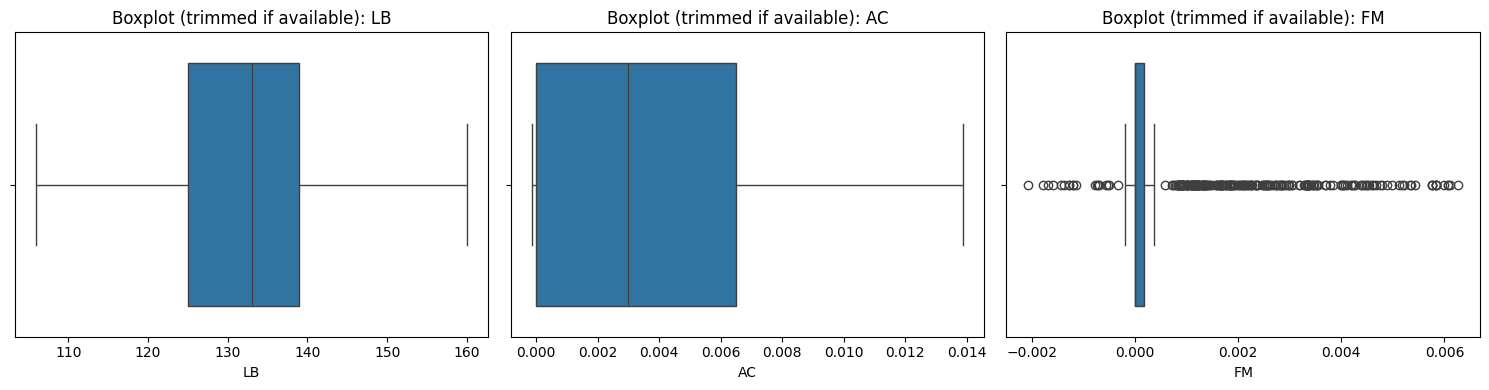

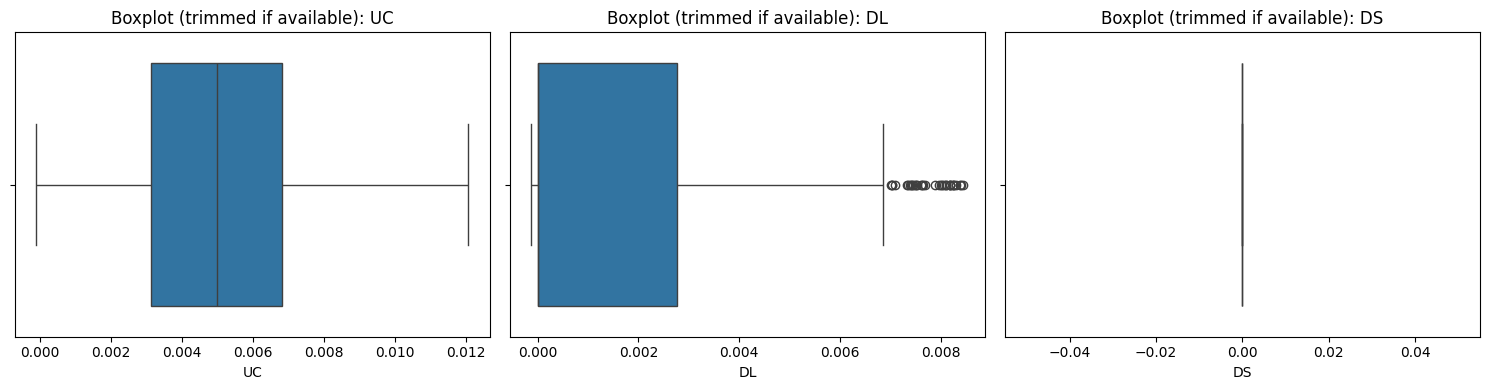

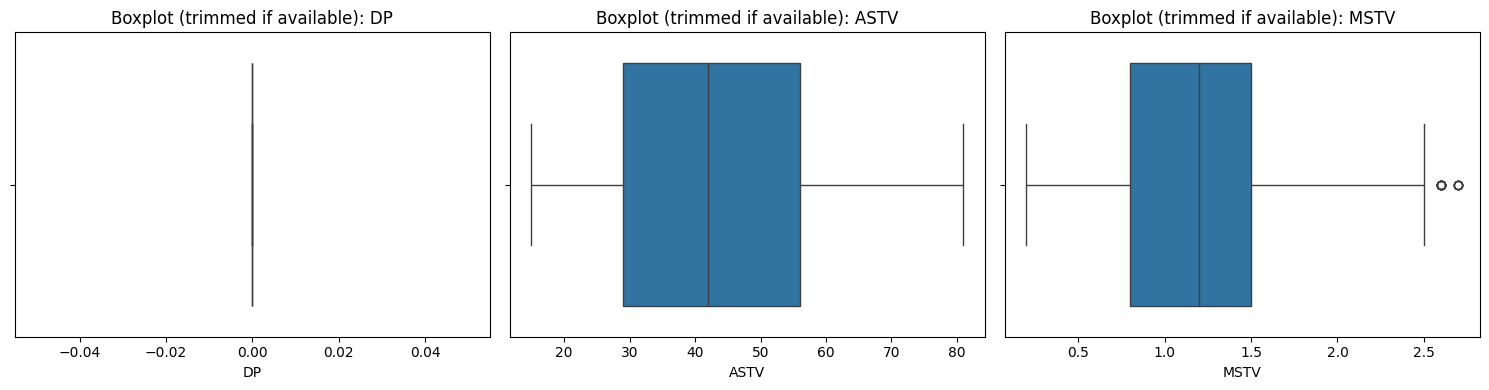

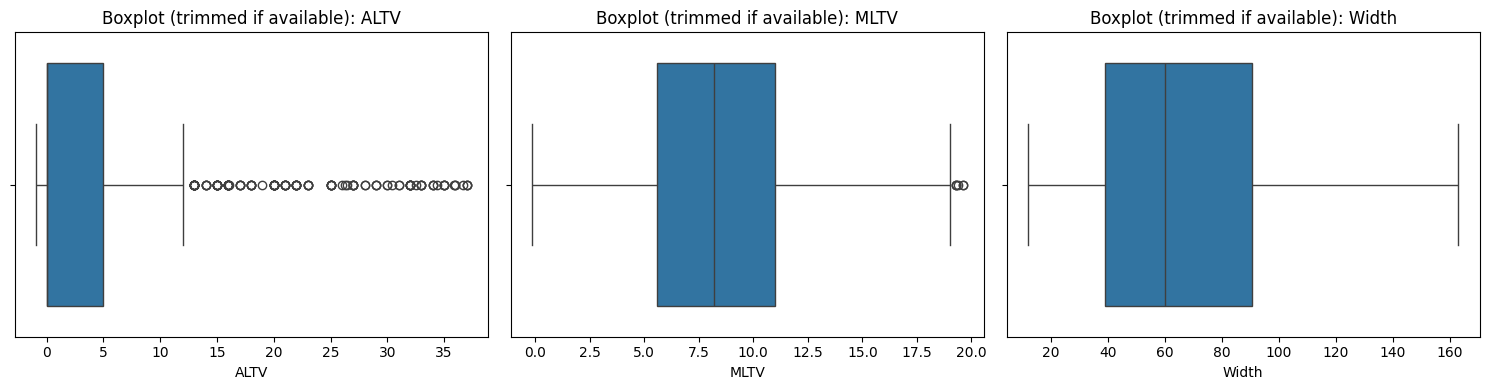

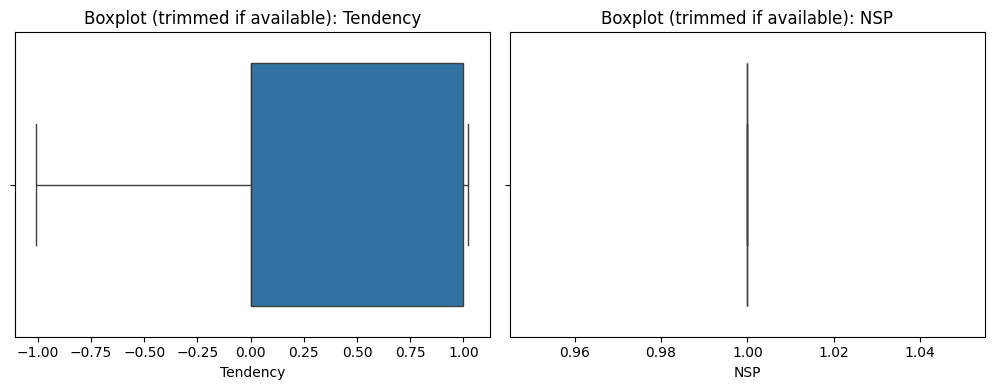

In [229]:
for i, col in enumerate(numeric_columns):
    if i % cols_per_row == 0:
        plt.figure(figsize=(15, 4))
    plt.subplot(1, cols_per_row, (i % cols_per_row) + 1)
    sns.boxplot(x=trimmed[col] if col in trimmed else imputed_df[col])
    plt.title(f'Boxplot (trimmed if available): {col}')
    plt.tight_layout()
    if (i % cols_per_row) == (cols_per_row - 1):
        plt.show()

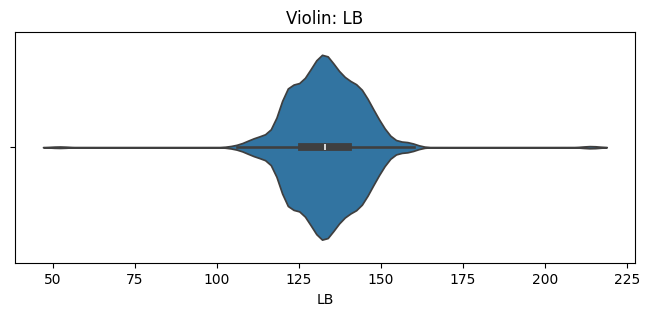

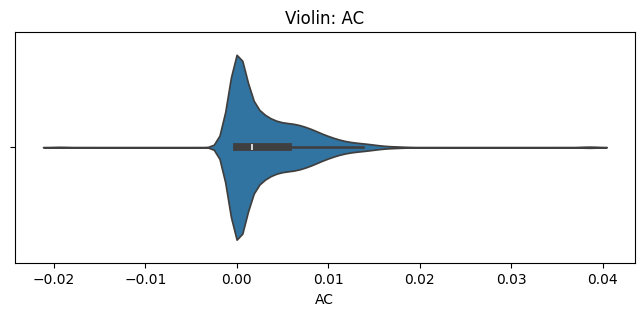

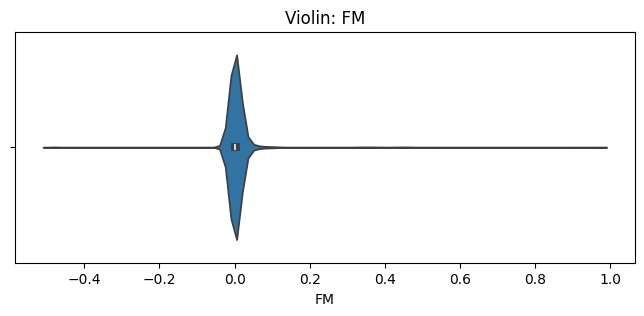

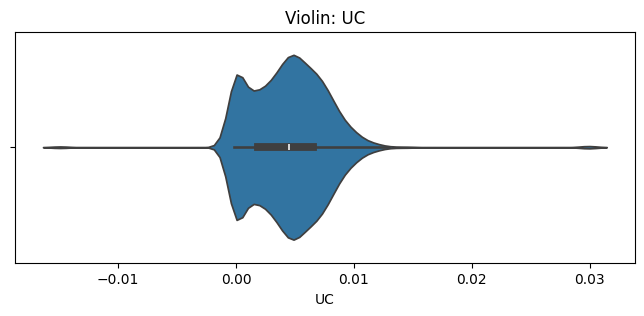

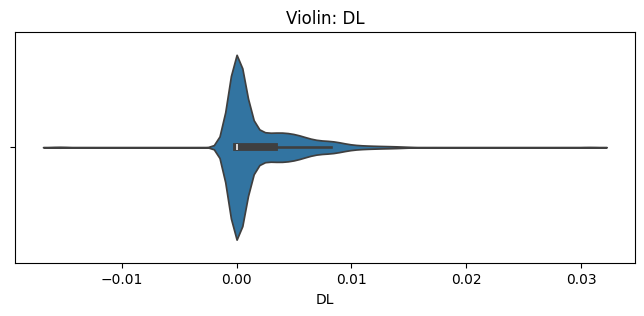

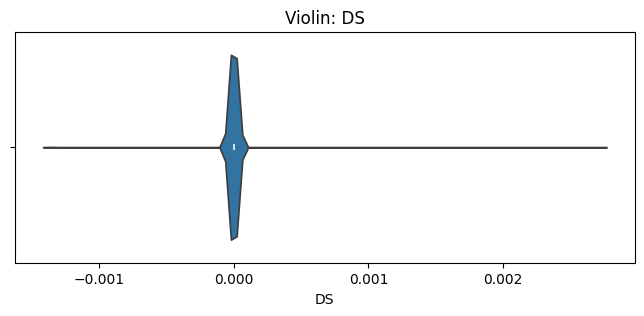

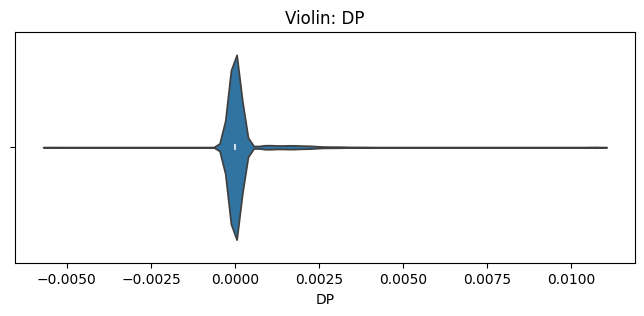

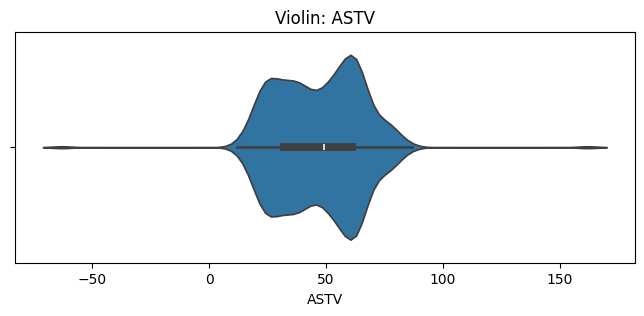

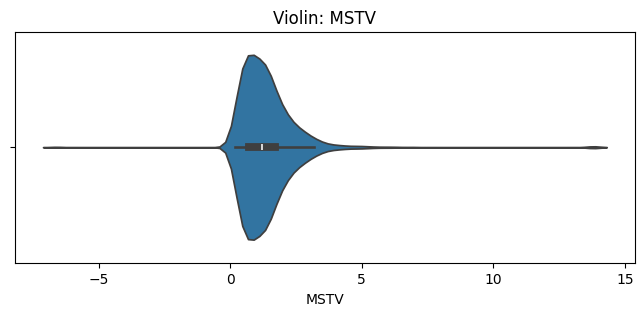

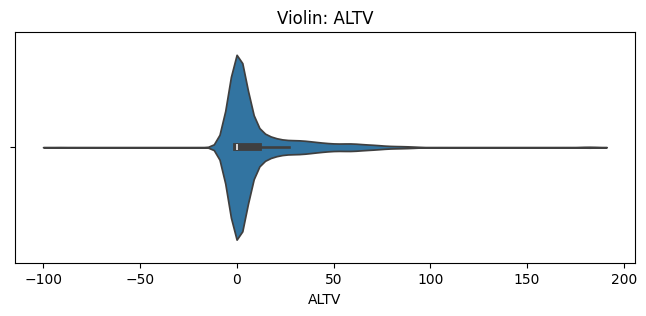

In [ ]:
for i, col in enumerate(numeric_columns):
    plt.figure(figsize=(8, 3))
    sns.violinplot(x=imputed_df[col])
    plt.title(f'Violin: {col}')
    plt.show()

# **Cell 9: Categorical variables frequency (if any**)

In [ ]:
cat_columns = imputed_df.select_dtypes(exclude=[np.number]).columns.tolist()
if cat_columns:
    for col in cat_columns:
        plt.figure(figsize=(8, 4))
        vc = imputed_df[col].value_counts().nlargest(20)
        sns.barplot(x=vc.values, y=vc.index)
        plt.title(f'Value counts: {col}')
        plt.xlabel('Count')
        plt.show()
else:
    print('No categorical columns detected.')

# **Cell 10: Correlation analysis**

In [ ]:
corr = imputed_df.select_dtypes(include=[np.number]).corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr, annot=True, fmt='.2f', cmap='vlag', center=0)
plt.title('Correlation heatmap')
plt.show()

# **Show strongest correlations (pairs**)

In [ ]:
corr_unstack = corr.abs().unstack().sort_values(kind='quicksort', ascending=False).drop_duplicates()

# **drop 1.0 self correlations**

In [ ]:
strong_pairs = corr_unstack[corr_unstack < 1.0].nlargest(20)
print('\nTop 20 strongest absolute correlations (pairs):')
print(strong_pairs)

# **Cell 11: Pairplot for selected variables (computationally heavy for many columns**)

In [ ]:
selected = numeric_columns[:6] # choose first 6 numeric columns for pairplot — change as needed
print('Pairplot variables:', selected)
sns.pairplot(imputed_df[selected].sample(min(1000, len(imputed_df)), random_state=42))
plt.show()

# **Cell 12: PCA for dimensionality reduction (optional**)

In [ ]:
X = imputed_df.select_dtypes(include=[np.number]).copy()
X = X.dropna()
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [ ]:
pca = PCA(n_components=min(10, X_scaled.shape[1]))
pcs = pca.fit_transform(X_scaled)

In [ ]:
explained = pca.explained_variance_ratio_
print('\nExplained variance ratio by component:')
for i, var in enumerate(explained, start=1):
    print(f'PC{i}: {var:.4f}')

In [ ]:
plt.figure(figsize=(8,4))
plt.plot(np.cumsum(explained), marker='o')
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.title('PCA — cumulative explained variance')
plt.grid(True)
plt.show()

# **Cell 13: Pattern recognition & insights (automated suggestions**)

In [ ]:
possible_baseline_cols = [c for c in imputed_df.columns if 'LB' in c or c.lower().startswith('lb')]
print('Possible baseline columns found:', possible_baseline_cols)

In [ ]:
if possible_baseline_cols:
    baseline = possible_baseline_cols[0]
    corrs_to_baseline = corr[baseline].abs().sort_values(ascending=False)
    print(f'Correlations with {baseline}:')
    print(corrs_to_baseline.head(10))

In [ ]:
insights = []
for col in corr.columns:
    highest = corr[col].abs().drop(col).nlargest(1)
    if not highest.empty and highest.iloc[0] > 0.6:
        pair_col = highest.index[0]
        insights.append((col, pair_col, corr.loc[col, pair_col]))

In [ ]:
print('\nAutomatically detected strongly correlated pairs (abs(corr) > 0.6):')
for a,b,val in insights:
    print(f'{a} <-> {b}: corr = {val:.3f}')

# **Cell 14: If temporal data exists — quick check**

In [ ]:
possible_time_cols = [c for c in imputed_df.columns if 'time' in c.lower() or 'date' in c.lower() or 'timestamp' in c.lower()]
print('Possible time columns:', possible_time_cols)

In [ ]:
if possible_time_cols:
    tcol = possible_time_cols[0]
    try:
        imputed_df[tcol] = pd.to_datetime(imputed_df[tcol])
        imputed_df.set_index(tcol, inplace=True)
        imputed_df.select_dtypes(include=[np.number]).rolling(window=5).mean().plot(figsize=(12,6))
        plt.title('Rolling mean of numeric features')
        plt.show()
    except Exception as e:
        print('Could not parse time column:', e)